In [2]:
from google.colab import files
files.upload()


Saving processed_dataset.zip to processed_dataset.zip


In [4]:
!ls /mnt/data


processed_dataset


In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
!cp /content/drive/MyDrive/processed_dataset.zip /mnt/data/


In [7]:
!ls /mnt/data


processed_dataset  processed_dataset.zip


In [8]:
import zipfile, os

zip_path = "/mnt/data/processed_dataset.zip"
extract_path = "/mnt/data/processed_dataset"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset extracted successfully")


✅ Dataset extracted successfully


In [9]:
!ls /mnt/data/processed_dataset


contrast  grayscale  rgb


In [10]:
!ls /mnt/data/processed_dataset/rgb


test  train  val


In [11]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.75, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),

    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.3,
        saturation=0.2
    ),

    transforms.RandomApply(
        [transforms.GaussianBlur(3, sigma=(0.1, 1.5))],
        p=0.3
    ),

    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [12]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

rgb_train = ImageFolder(
    root="/mnt/data/processed_dataset/rgb/train",
    transform=train_transforms
)

rgb_val = ImageFolder(
    root="/mnt/data/processed_dataset/rgb/val",
    transform=val_test_transforms
)

rgb_test = ImageFolder(
    root="/mnt/data/processed_dataset/rgb/test",
    transform=val_test_transforms
)

rgb_train_loader = DataLoader(rgb_train, batch_size=32, shuffle=True, num_workers=4)
rgb_val_loader   = DataLoader(rgb_val, batch_size=32, shuffle=False)
rgb_test_loader  = DataLoader(rgb_test, batch_size=32, shuffle=False)

print("RGB Train:", len(rgb_train))
print("RGB Val:", len(rgb_val))
print("RGB Test:", len(rgb_test))


RGB Train: 3142
RGB Val: 2412
RGB Test: 1862


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [13]:
gray_train = ImageFolder(
    root="/mnt/data/processed_dataset/grayscale/train",
    transform=train_transforms
)

gray_train_loader = DataLoader(gray_train, batch_size=32, shuffle=True, num_workers=4)


In [14]:
contrast_train = ImageFolder(
    root="/mnt/data/processed_dataset/contrast/train",
    transform=train_transforms
)

contrast_train_loader = DataLoader(contrast_train, batch_size=32, shuffle=True, num_workers=4)


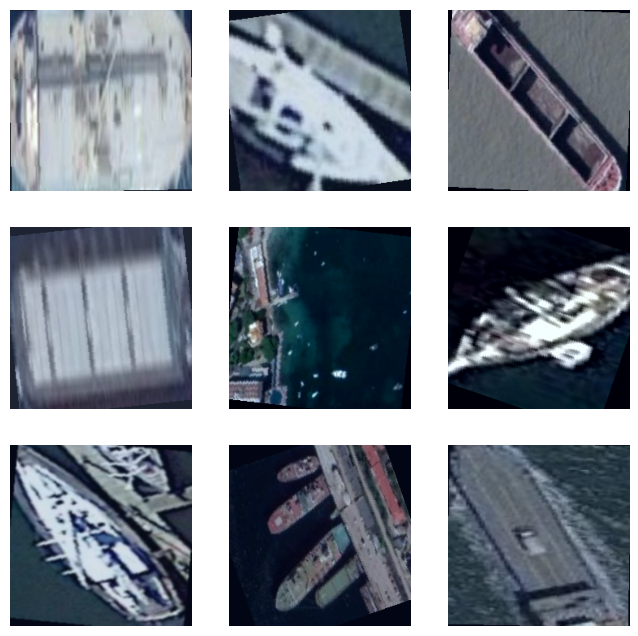

In [15]:
#Visual Check
import matplotlib.pyplot as plt

images, labels = next(iter(rgb_train_loader))

plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    img = images[i].permute(1,2,0)
    img = img * 0.225 + 0.45
    plt.imshow(img)
    plt.axis("off")
plt.show()


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


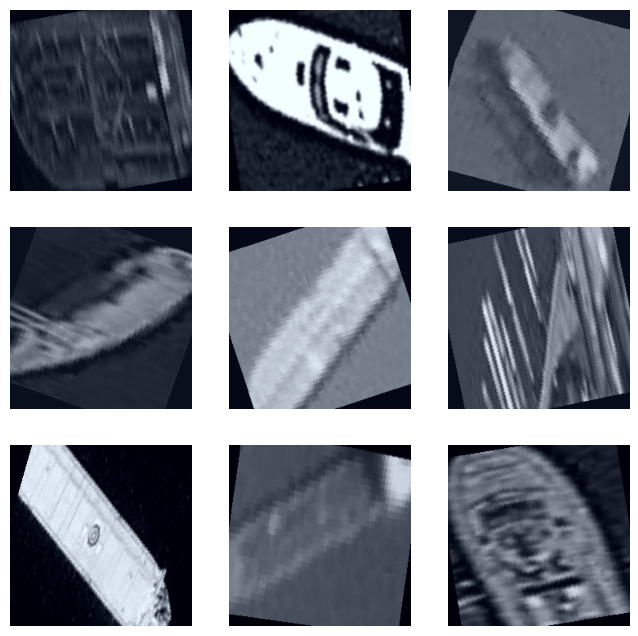

In [16]:
import matplotlib.pyplot as plt

images, labels = next(iter(gray_train_loader))

plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    img = images[i].permute(1,2,0)
    img = img * 0.225 + 0.45
    plt.imshow(img)
    plt.axis("off")
plt.show()


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


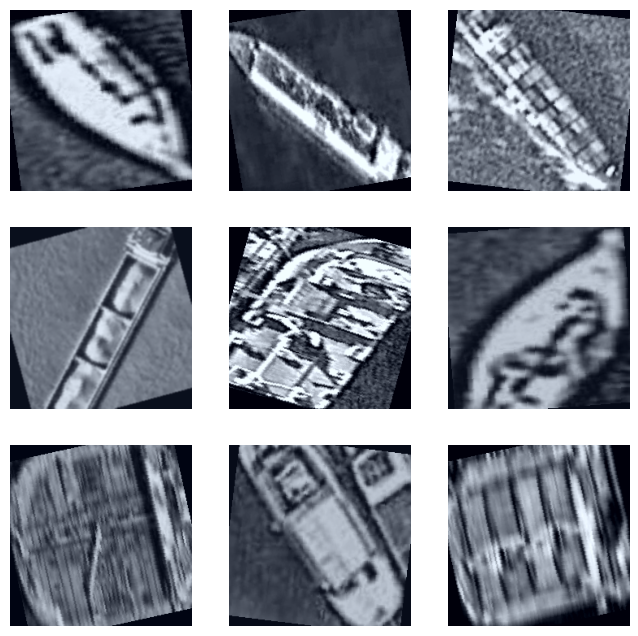

In [17]:
import matplotlib.pyplot as plt

images, labels = next(iter(contrast_train_loader))

plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    img = images[i].permute(1,2,0)
    img = img * 0.225 + 0.45
    plt.imshow(img)
    plt.axis("off")
plt.show()


In [18]:
!pip install -q timm


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import timm


In [20]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.75, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.3),
    transforms.RandomApply([transforms.GaussianBlur(3)], p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [21]:
train_dir = "/mnt/data/processed_dataset/rgb/train"
val_dir   = "/mnt/data/processed_dataset/rgb/val"
test_dir  = "/mnt/data/processed_dataset/rgb/test"

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset   = datasets.ImageFolder(val_dir, transform=val_test_transforms)
test_dataset  = datasets.ImageFolder(test_dir, transform=val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_classes = len(train_dataset.classes)
print("Classes:", train_dataset.classes)


Classes: ['ship']


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model(
    "efficientnet_b0",
    pretrained=True,
    num_classes=num_classes
)

model = model.to(device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [23]:
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True


In [24]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    model.classifier.parameters(),
    lr=1e-3
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=3, factor=0.3
)


In [25]:
def train_model(model, epochs=10):
    best_val_acc = 0

    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total
        scheduler.step(val_loss)

        print(f"""
Epoch [{epoch+1}/{epochs}]
Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}
Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}
        """)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_effnet_b0_rgb.pth")

    print("✅ Training complete")


In [26]:
train_model(model, epochs=10)



Epoch [1/10]
Train Loss: 0.0000 | Train Acc: 1.0000
Val   Loss: 0.0000 | Val   Acc: 1.0000
        

Epoch [2/10]
Train Loss: 0.0000 | Train Acc: 1.0000
Val   Loss: 0.0000 | Val   Acc: 1.0000
        

Epoch [3/10]
Train Loss: 0.0000 | Train Acc: 1.0000
Val   Loss: 0.0000 | Val   Acc: 1.0000
        

Epoch [4/10]
Train Loss: 0.0000 | Train Acc: 1.0000
Val   Loss: 0.0000 | Val   Acc: 1.0000
        

Epoch [5/10]
Train Loss: 0.0000 | Train Acc: 1.0000
Val   Loss: 0.0000 | Val   Acc: 1.0000
        

Epoch [6/10]
Train Loss: 0.0000 | Train Acc: 1.0000
Val   Loss: 0.0000 | Val   Acc: 1.0000
        

Epoch [7/10]
Train Loss: 0.0000 | Train Acc: 1.0000
Val   Loss: 0.0000 | Val   Acc: 1.0000
        

Epoch [8/10]
Train Loss: 0.0000 | Train Acc: 1.0000
Val   Loss: 0.0000 | Val   Acc: 1.0000
        

Epoch [9/10]
Train Loss: 0.0000 | Train Acc: 1.0000
Val   Loss: 0.0000 | Val   Acc: 1.0000
        

Epoch [10/10]
Train Loss: 0.0000 | Train Acc: 1.0000
Val   Loss: 0.0000 | Val   Acc: 1.000

In [27]:
model.load_state_dict(torch.load("best_effnet_b0_rgb.pth"))
model.eval()

correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print("Test Accuracy:", correct / total)


Test Accuracy: 1.0


In [28]:
train_transforms_gray = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # IMPORTANT
    transforms.RandomResizedCrop(224, scale=(0.75, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),

    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.3
    ),

    transforms.RandomApply(
        [transforms.GaussianBlur(3, sigma=(0.1, 1.5))],
        p=0.3
    ),

    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [29]:
val_test_transforms_gray = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [30]:
train_dir = "/mnt/data/processed_dataset/grayscale/train"
val_dir   = "/mnt/data/processed_dataset/grayscale/val"
test_dir  = "/mnt/data/processed_dataset/grayscale/test"

train_dataset = datasets.ImageFolder(
    train_dir, transform=train_transforms_gray
)
val_dataset = datasets.ImageFolder(
    val_dir, transform=val_test_transforms_gray
)
test_dataset = datasets.ImageFolder(
    test_dir, transform=val_test_transforms_gray
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_classes = len(train_dataset.classes)
print("Classes:", train_dataset.classes)


Classes: ['ship']


In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model(
    "efficientnet_b0",
    pretrained=True,
    num_classes=num_classes
)

model = model.to(device)


In [32]:
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True


In [33]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    model.classifier.parameters(),
    lr=1e-3
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    patience=3,
    factor=0.3
)


In [34]:
def train_model(model, epochs=10):
    best_val_acc = 0.0

    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total

        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total
        scheduler.step(val_loss)

        print(f"""
Epoch [{epoch+1}/{epochs}]
Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}
Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}
        """)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_effnet_b0_gray.pth")

    print("✅ Grayscale training complete")


In [35]:
train_model(model, epochs=10)



Epoch [1/10]
Train Loss: 0.0000 | Train Acc: 1.0000
Val   Loss: 0.0000 | Val   Acc: 1.0000
        

Epoch [2/10]
Train Loss: 0.0000 | Train Acc: 1.0000
Val   Loss: 0.0000 | Val   Acc: 1.0000
        

Epoch [3/10]
Train Loss: 0.0000 | Train Acc: 1.0000
Val   Loss: 0.0000 | Val   Acc: 1.0000
        

Epoch [4/10]
Train Loss: 0.0000 | Train Acc: 1.0000
Val   Loss: 0.0000 | Val   Acc: 1.0000
        

Epoch [5/10]
Train Loss: 0.0000 | Train Acc: 1.0000
Val   Loss: 0.0000 | Val   Acc: 1.0000
        

Epoch [6/10]
Train Loss: 0.0000 | Train Acc: 1.0000
Val   Loss: 0.0000 | Val   Acc: 1.0000
        

Epoch [7/10]
Train Loss: 0.0000 | Train Acc: 1.0000
Val   Loss: 0.0000 | Val   Acc: 1.0000
        

Epoch [8/10]
Train Loss: 0.0000 | Train Acc: 1.0000
Val   Loss: 0.0000 | Val   Acc: 1.0000
        

Epoch [9/10]
Train Loss: 0.0000 | Train Acc: 1.0000
Val   Loss: 0.0000 | Val   Acc: 1.0000
        

Epoch [10/10]
Train Loss: 0.0000 | Train Acc: 1.0000
Val   Loss: 0.0000 | Val   Acc: 1.000

In [36]:
model.load_state_dict(torch.load("best_effnet_b0_gray.pth"))
model.eval()

correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print("Grayscale Test Accuracy:", correct / total)


Grayscale Test Accuracy: 1.0


In [37]:
train_transforms_contrast = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.75, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),

    # very mild jitter (important)
    transforms.ColorJitter(
        brightness=0.1,
        contrast=0.1
    ),

    transforms.RandomApply(
        [transforms.GaussianBlur(3, sigma=(0.1, 1.2))],
        p=0.25
    ),

    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_test_transforms_contrast = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [38]:
train_dir = "/mnt/data/processed_dataset/contrast/train"
val_dir   = "/mnt/data/processed_dataset/contrast/val"
test_dir  = "/mnt/data/processed_dataset/contrast/test"

train_dataset = datasets.ImageFolder(
    train_dir, transform=train_transforms_contrast
)
val_dataset = datasets.ImageFolder(
    val_dir, transform=val_test_transforms_contrast
)
test_dataset = datasets.ImageFolder(
    test_dir, transform=val_test_transforms_contrast
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_classes = len(train_dataset.classes)
print("Classes:", train_dataset.classes)


Classes: ['ship']


In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model(
    "efficientnet_b0",
    pretrained=True,
    num_classes=num_classes
)

model = model.to(device)


In [40]:
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True


In [41]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    model.classifier.parameters(),
    lr=1e-3
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    patience=3,
    factor=0.3
)


In [42]:
def train_model(model, epochs=10):
    best_val_acc = 0.0

    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total

        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total
        scheduler.step(val_loss)

        print(f"""
Epoch [{epoch+1}/{epochs}]
Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}
Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}
        """)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_effnet_b0_contrast.pth")

    print("✅ Contrast training complete")


In [43]:
train_model(model, epochs=10)



Epoch [1/10]
Train Loss: 0.0000 | Train Acc: 1.0000
Val   Loss: 0.0000 | Val   Acc: 1.0000
        

Epoch [2/10]
Train Loss: 0.0000 | Train Acc: 1.0000
Val   Loss: 0.0000 | Val   Acc: 1.0000
        

Epoch [3/10]
Train Loss: 0.0000 | Train Acc: 1.0000
Val   Loss: 0.0000 | Val   Acc: 1.0000
        

Epoch [4/10]
Train Loss: 0.0000 | Train Acc: 1.0000
Val   Loss: 0.0000 | Val   Acc: 1.0000
        

Epoch [5/10]
Train Loss: 0.0000 | Train Acc: 1.0000
Val   Loss: 0.0000 | Val   Acc: 1.0000
        

Epoch [6/10]
Train Loss: 0.0000 | Train Acc: 1.0000
Val   Loss: 0.0000 | Val   Acc: 1.0000
        

Epoch [7/10]
Train Loss: 0.0000 | Train Acc: 1.0000
Val   Loss: 0.0000 | Val   Acc: 1.0000
        

Epoch [8/10]
Train Loss: 0.0000 | Train Acc: 1.0000
Val   Loss: 0.0000 | Val   Acc: 1.0000
        

Epoch [9/10]
Train Loss: 0.0000 | Train Acc: 1.0000
Val   Loss: 0.0000 | Val   Acc: 1.0000
        

Epoch [10/10]
Train Loss: 0.0000 | Train Acc: 1.0000
Val   Loss: 0.0000 | Val   Acc: 1.000

In [44]:
model.load_state_dict(torch.load("best_effnet_b0_contrast.pth"))
model.eval()

correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print("Contrast Test Accuracy:", correct / total)


Contrast Test Accuracy: 1.0


In [45]:
import torch
import timm
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = len(train_dataset.classes)  # same for all
class_names = train_dataset.classes


In [46]:
def load_model(weight_path):
    model = timm.create_model(
        "efficientnet_b0",
        pretrained=False,
        num_classes=num_classes
    )
    model.load_state_dict(torch.load(weight_path, map_location=device))
    model.to(device)
    model.eval()
    return model

model_rgb = load_model("best_effnet_b0_rgb.pth")
model_gray = load_model("best_effnet_b0_gray.pth")
model_contrast = load_model("best_effnet_b0_contrast.pth")


In [48]:
#Single image Ensemble prediction
def ensemble_predict(img_rgb, img_gray, img_contrast):
    with torch.no_grad():
        p_rgb = F.softmax(model_rgb(img_rgb), dim=1)
        p_gray = F.softmax(model_gray(img_gray), dim=1)
        p_contrast = F.softmax(model_contrast(img_contrast), dim=1)

        p_final = (p_rgb + p_gray + p_contrast) / 3

        conf, pred = torch.max(p_final, 1)

    return class_names[pred.item()], conf.item()



In [50]:
from torchvision import transforms

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# For grayscale specifically
val_test_transforms_gray = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [51]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# RGB
rgb_test_dataset = ImageFolder(
    "/mnt/data/processed_dataset/rgb/test",
    transform=val_test_transforms
)

# Grayscale
gray_test_dataset = ImageFolder(
    "/mnt/data/processed_dataset/grayscale/test",
    transform=val_test_transforms_gray
)

# Contrast
contrast_test_dataset = ImageFolder(
    "/mnt/data/processed_dataset/contrast/test",
    transform=val_test_transforms
)


In [52]:
rgb_test_loader = DataLoader(
    rgb_test_dataset, batch_size=32, shuffle=False
)

gray_test_loader = DataLoader(
    gray_test_dataset, batch_size=32, shuffle=False
)

contrast_test_loader = DataLoader(
    contrast_test_dataset, batch_size=32, shuffle=False
)


In [53]:
import torch.nn.functional as F

correct, total = 0, 0

for (rgb_img, y), (gray_img, _), (con_img, _) in zip(
        rgb_test_loader, gray_test_loader, contrast_test_loader):

    rgb_img = rgb_img.to(device)
    gray_img = gray_img.to(device)
    con_img = con_img.to(device)
    y = y.to(device)

    with torch.no_grad():
        p = (
            F.softmax(model_rgb(rgb_img), dim=1) +
            F.softmax(model_gray(gray_img), dim=1) +
            F.softmax(model_contrast(con_img), dim=1)
        ) / 3

        preds = torch.argmax(p, dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

print("🔥 Ensemble Test Accuracy:", correct / total)


🔥 Ensemble Test Accuracy: 1.0


In [54]:
print(len(rgb_test_dataset), len(gray_test_dataset), len(contrast_test_dataset))


1862 1862 1862


In [55]:
print(rgb_test_dataset.root)
print(gray_test_dataset.root)
print(contrast_test_dataset.root)


/mnt/data/processed_dataset/rgb/test
/mnt/data/processed_dataset/grayscale/test
/mnt/data/processed_dataset/contrast/test


In [57]:
rgb_files = rgb_test_dataset.samples
gray_files = gray_test_dataset.samples
contrast_files = contrast_test_dataset.samples

for i in range(10):
    print(
        rgb_files[i][0].split("/")[-1],
        gray_files[i][0].split("/")[-1],
        contrast_files[i][0].split("/")[-1]
    )


02e39612d_jpg.rf.cc5483bb711f080d12b644ff62cf977a_0.jpg 02e39612d_jpg.rf.cc5483bb711f080d12b644ff62cf977a_0.jpg 02e39612d_jpg.rf.cc5483bb711f080d12b644ff62cf977a_0.jpg
04-33800_jpg.rf.c45762dfac8f4c20534434159df41ad2_0.jpg 04-33800_jpg.rf.c45762dfac8f4c20534434159df41ad2_0.jpg 04-33800_jpg.rf.c45762dfac8f4c20534434159df41ad2_0.jpg
043d8815e_jpg.rf.702fa31e03a8a1c28e5fb63c561ac16e_0.jpg 043d8815e_jpg.rf.702fa31e03a8a1c28e5fb63c561ac16e_0.jpg 043d8815e_jpg.rf.702fa31e03a8a1c28e5fb63c561ac16e_0.jpg
043d8815e_jpg.rf.702fa31e03a8a1c28e5fb63c561ac16e_4.jpg 043d8815e_jpg.rf.702fa31e03a8a1c28e5fb63c561ac16e_4.jpg 043d8815e_jpg.rf.702fa31e03a8a1c28e5fb63c561ac16e_4.jpg
0__20160905_193458_0c37__-122-34588841807276_37-756417599310865_png.rf.82197eb6853000003827a752a1c02a47_0.jpg 0__20160905_193458_0c37__-122-34588841807276_37-756417599310865_png.rf.82197eb6853000003827a752a1c02a47_0.jpg 0__20160905_193458_0c37__-122-34588841807276_37-756417599310865_png.rf.82197eb6853000003827a752a1c02a47_0.jpg
0

In [59]:
import torch
import timm
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = len(rgb_test_dataset.classes)
class_names = rgb_test_dataset.classes

def load_model(path):
    model = timm.create_model(
        "efficientnet_b0",
        pretrained=False,
        num_classes=num_classes
    )
    model.load_state_dict(torch.load(path, map_location=device))
    model.to(device)
    model.eval()
    return model

model_rgb = load_model("best_effnet_b0_rgb.pth")
model_gray = load_model("best_effnet_b0_gray.pth")
model_contrast = load_model("best_effnet_b0_contrast.pth")


In [60]:
# filename -> true label
gt_map = {}

for path, label in rgb_test_dataset.samples:
    fname = path.split("/")[-1]
    gt_map[fname] = label


In [61]:
pred_rgb = {}

with torch.no_grad():
    for imgs, labels in rgb_test_loader:
        imgs = imgs.to(device)
        outputs = F.softmax(model_rgb(imgs), dim=1)

        for i in range(imgs.size(0)):
            fname = rgb_test_dataset.samples[len(pred_rgb)][0].split("/")[-1]
            pred_rgb[fname] = outputs[i].cpu()


In [62]:
pred_gray = {}

with torch.no_grad():
    for imgs, labels in gray_test_loader:
        imgs = imgs.to(device)
        outputs = F.softmax(model_gray(imgs), dim=1)

        for i in range(imgs.size(0)):
            fname = gray_test_dataset.samples[len(pred_gray)][0].split("/")[-1]
            pred_gray[fname] = outputs[i].cpu()


In [63]:
pred_contrast = {}

with torch.no_grad():
    for imgs, labels in contrast_test_loader:
        imgs = imgs.to(device)
        outputs = F.softmax(model_contrast(imgs), dim=1)

        for i in range(imgs.size(0)):
            fname = contrast_test_dataset.samples[len(pred_contrast)][0].split("/")[-1]
            pred_contrast[fname] = outputs[i].cpu()


In [64]:
correct = 0
total = 0

for fname in gt_map.keys():

    # safety check
    if fname not in pred_rgb or fname not in pred_gray or fname not in pred_contrast:
        continue

    p_final = (
        pred_rgb[fname] +
        pred_gray[fname] +
        pred_contrast[fname]
    ) / 3

    pred = torch.argmax(p_final).item()
    true = gt_map[fname]

    if pred == true:
        correct += 1
    total += 1

print("✅ Correct Ensemble Accuracy:", correct / total)


✅ Correct Ensemble Accuracy: 1.0


In [65]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize


In [66]:
y_true = []
y_pred = []
y_conf = []

for fname in gt_map.keys():
    if fname not in pred_rgb or fname not in pred_gray or fname not in pred_contrast:
        continue

    p_final = (
        pred_rgb[fname] +
        pred_gray[fname] +
        pred_contrast[fname]
    ) / 3

    pred_class = torch.argmax(p_final).item()
    confidence = torch.max(p_final).item()

    y_true.append(gt_map[fname])
    y_pred.append(pred_class)
    y_conf.append(confidence)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_conf = np.array(y_conf)


In [67]:
print("Accuracy :", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred, average="weighted"))
print("Recall   :", recall_score(y_true, y_pred, average="weighted"))
print("F1 Score :", f1_score(y_true, y_pred, average="weighted"))

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


Accuracy : 1.0
Precision: 1.0
Recall   : 1.0
F1 Score : 1.0

Classification Report:

              precision    recall  f1-score   support

        ship       1.00      1.00      1.00      1862

    accuracy                           1.00      1862
   macro avg       1.00      1.00      1.00      1862
weighted avg       1.00      1.00      1.00      1862



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


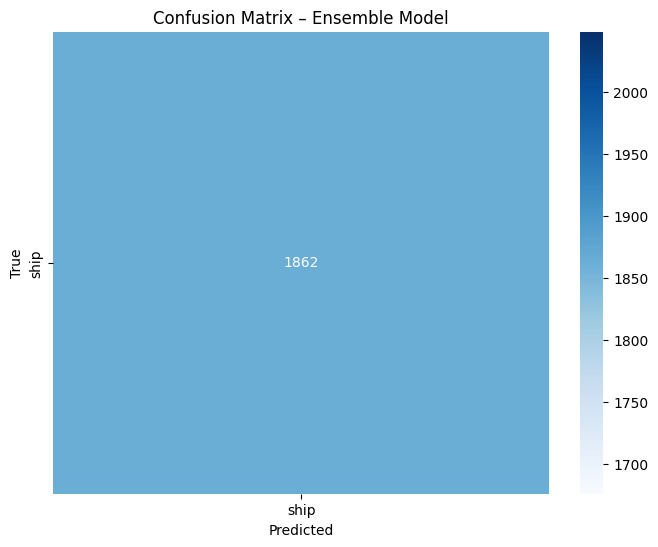

In [68]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – Ensemble Model")
plt.show()


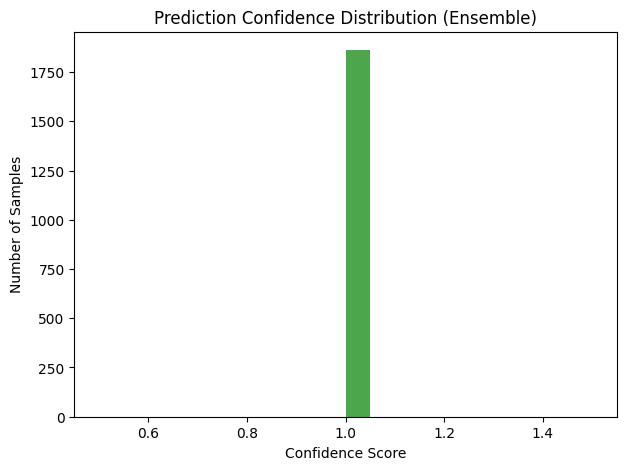

In [69]:
plt.figure(figsize=(7,5))
plt.hist(y_conf, bins=20, color="green", alpha=0.7)
plt.xlabel("Confidence Score")
plt.ylabel("Number of Samples")
plt.title("Prediction Confidence Distribution (Ensemble)")
plt.show()


In [70]:
from google.colab import files

files.download("best_effnet_b0_rgb.pth")
files.download("best_effnet_b0_gray.pth")
files.download("best_effnet_b0_contrast.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [71]:
import torch
import torch.nn as nn
import timm

class MultiModalEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.rgb_net = timm.create_model(
            "efficientnet_b0", pretrained=True, num_classes=0
        )
        self.gray_net = timm.create_model(
            "efficientnet_b0", pretrained=True, num_classes=0
        )
        self.contrast_net = timm.create_model(
            "efficientnet_b0", pretrained=True, num_classes=0
        )

        fusion_dim = (
            self.rgb_net.num_features +
            self.gray_net.num_features +
            self.contrast_net.num_features
        )

        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, rgb, gray, contrast):
        f_rgb = self.rgb_net(rgb)
        f_gray = self.gray_net(gray)
        f_con = self.contrast_net(contrast)

        fused = torch.cat([f_rgb, f_gray, f_con], dim=1)
        return self.classifier(fused)


In [72]:
model = MultiModalEfficientNet(num_classes).to(device)

model.rgb_net.load_state_dict(
    torch.load("best_effnet_b0_rgb.pth"), strict=False
)
model.gray_net.load_state_dict(
    torch.load("best_effnet_b0_gray.pth"), strict=False
)
model.contrast_net.load_state_dict(
    torch.load("best_effnet_b0_contrast.pth"), strict=False
)


_IncompatibleKeys(missing_keys=[], unexpected_keys=['classifier.weight', 'classifier.bias'])

In [73]:
for net in [model.rgb_net, model.gray_net, model.contrast_net]:
    for p in net.parameters():
        p.requires_grad = False


In [74]:
trainable = sum(p.requires_grad for p in model.parameters())
total = sum(1 for _ in model.parameters())

print(f"Trainable params: {trainable} / {total}")


Trainable params: 4 / 637


In [75]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    model.classifier.parameters(),  # IMPORTANT
    lr=1e-3
)


In [76]:
from torch.utils.data import Dataset
from PIL import Image
import os

class MultiModalDataset(Dataset):
    def __init__(self, rgb_root, gray_root, contrast_root, transform_rgb, transform_gray):
        self.rgb_root = rgb_root
        self.gray_root = gray_root
        self.contrast_root = contrast_root
        self.transform_rgb = transform_rgb
        self.transform_gray = transform_gray

        self.samples = []
        for cls in os.listdir(rgb_root):
            rgb_cls = os.path.join(rgb_root, cls)
            for fname in os.listdir(rgb_cls):
                self.samples.append((cls, fname))

        self.class_to_idx = {cls: i for i, cls in enumerate(sorted(os.listdir(rgb_root)))}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        cls, fname = self.samples[idx]

        rgb_path = os.path.join(self.rgb_root, cls, fname)
        gray_path = os.path.join(self.gray_root, cls, fname)
        contrast_path = os.path.join(self.contrast_root, cls, fname)

        rgb = self.transform_rgb(Image.open(rgb_path).convert("RGB"))
        gray = self.transform_gray(Image.open(gray_path))
        contrast = self.transform_rgb(Image.open(contrast_path).convert("RGB"))

        label = self.class_to_idx[cls]

        return rgb, gray, contrast, label


In [79]:
import os
import random

rgb_test_root = "/mnt/data/processed_dataset/rgb/test"

# pick a random class
cls = random.choice(os.listdir(rgb_test_root))

# pick a random image from that class
fname = random.choice(os.listdir(os.path.join(rgb_test_root, cls)))

rgb_path = os.path.join(rgb_test_root, cls, fname)
gray_path = f"/mnt/data/processed_dataset/grayscale/test/{cls}/{fname}"
contrast_path = f"/mnt/data/processed_dataset/contrast/test/{cls}/{fname}"

print("Class folder (ground truth):", cls)
print("Filename:", fname)


Class folder (ground truth): ship
Filename: SA_687_jpg.rf.48147ec577907a6c1af8d1bad547e735_1.jpg


In [80]:
import os
import random

rgb_test_root = "/mnt/data/processed_dataset/rgb/test"

# pick a random class
cls = random.choice(os.listdir(rgb_test_root))

# pick a random image from that class
fname = random.choice(os.listdir(os.path.join(rgb_test_root, cls)))

rgb_path = os.path.join(rgb_test_root, cls, fname)
gray_path = f"/mnt/data/processed_dataset/grayscale/test/{cls}/{fname}"
contrast_path = f"/mnt/data/processed_dataset/contrast/test/{cls}/{fname}"

print("Class folder (ground truth):", cls)
print("Filename:", fname)


Class folder (ground truth): ship
Filename: c277a35f2_jpg.rf.f3157bc856be08a46f5560306590c1b3_4.jpg


In [81]:
import torch
import torch.nn.functional as F

def classify_single_image(rgb_path, gray_path, contrast_path):
    rgb = transform_rgb(Image.open(rgb_path).convert("RGB")).unsqueeze(0).to(device)
    gray = transform_gray(Image.open(gray_path)).unsqueeze(0).to(device)
    contrast = transform_rgb(Image.open(contrast_path).convert("RGB")).unsqueeze(0).to(device)

    with torch.no_grad():
        p_rgb = F.softmax(model_rgb(rgb), dim=1)
        p_gray = F.softmax(model_gray(gray), dim=1)
        p_con = F.softmax(model_contrast(contrast), dim=1)

        p_final = (p_rgb + p_gray + p_con) / 3
        conf, pred = torch.max(p_final, 1)

    return class_names[pred.item()], conf.item()


In [83]:
import torch
import timm
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = len(class_names)  # reuse from training

model_rgb = timm.create_model(
    "efficientnet_b0",
    pretrained=False,
    num_classes=num_classes
)

model_rgb.load_state_dict(torch.load("best_effnet_b0_rgb.pth", map_location=device))
model_rgb.to(device)
model_rgb.eval()


EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

In [84]:
from torchvision import transforms
from PIL import Image

transform_rgb = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [85]:
import os, random

rgb_test_root = "/mnt/data/processed_dataset/rgb/test"

true_class = random.choice(os.listdir(rgb_test_root))
fname = random.choice(os.listdir(os.path.join(rgb_test_root, true_class)))

img_path = os.path.join(rgb_test_root, true_class, fname)

print("Ground Truth Class:", true_class)
print("Filename:", fname)


Ground Truth Class: ship
Filename: d0003_png.rf.2f66e0edf6ca47fe60072754e297c801_0.jpg


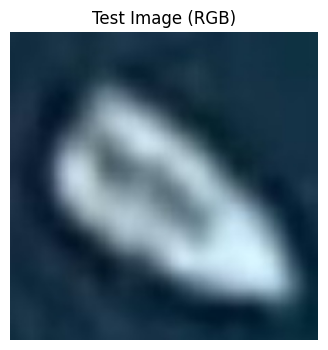

In [86]:
import matplotlib.pyplot as plt

img = Image.open(img_path).convert("RGB")

plt.figure(figsize=(4,4))
plt.imshow(img)
plt.axis("off")
plt.title("Test Image (RGB)")
plt.show()


In [87]:
def classify_rgb_image(img_path):
    img = transform_rgb(Image.open(img_path).convert("RGB")).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model_rgb(img)
        probs = F.softmax(logits, dim=1)
        conf, pred = torch.max(probs, 1)

    return class_names[pred.item()], conf.item()


In [88]:
predicted_class, confidence = classify_rgb_image(img_path)

print("Predicted Class :", predicted_class)
print("Confidence      :", round(confidence, 4))


Predicted Class : ship
Confidence      : 1.0


In [89]:
class FusedShipClassifier:
    def __init__(self, model_rgb, model_gray, model_contrast):
        self.model_rgb = model_rgb
        self.model_gray = model_gray
        self.model_contrast = model_contrast

    def predict(self, rgb_tensor, gray_tensor, contrast_tensor):
        with torch.no_grad():
            p_rgb = F.softmax(self.model_rgb(rgb_tensor), dim=1)
            p_gray = F.softmax(self.model_gray(gray_tensor), dim=1)
            p_con = F.softmax(self.model_contrast(contrast_tensor), dim=1)

            p_final = (p_rgb + p_gray + p_con) / 3
            conf, pred = torch.max(p_final, dim=1)

        return pred.item(), conf.item()


In [90]:
from torchvision import transforms
from PIL import Image

transform_rgb = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

transform_gray = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [91]:
fused_model = FusedShipClassifier(
    model_rgb,
    model_gray,
    model_contrast
)


In [92]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FusedEfficientNet(nn.Module):
    def __init__(self, model_rgb, model_gray, model_contrast):
        super().__init__()
        self.model_rgb = model_rgb
        self.model_gray = model_gray
        self.model_contrast = model_contrast

    def forward(self, rgb, gray, contrast):
        p_rgb = F.softmax(self.model_rgb(rgb), dim=1)
        p_gray = F.softmax(self.model_gray(gray), dim=1)
        p_con = F.softmax(self.model_contrast(contrast), dim=1)

        p_final = (p_rgb + p_gray + p_con) / 3
        return p_final


In [93]:
fused_model = FusedEfficientNet(
    model_rgb,
    model_gray,
    model_contrast
).to(device)

fused_model.eval()


FusedEfficientNet(
  (model_rgb): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv

In [94]:
dummy_rgb = torch.randn(1, 3, 224, 224).to(device)
dummy_gray = torch.randn(1, 3, 224, 224).to(device)
dummy_contrast = torch.randn(1, 3, 224, 224).to(device)

fused_traced = torch.jit.trace(
    fused_model,
    (dummy_rgb, dummy_gray, dummy_contrast)
)


In [96]:
fused_traced.save("fused_ship_classifier.pth")


In [97]:
from google.colab import files
files.download("fused_ship_classifier.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>